<div style="float: block; text-align: center; line-height: 1.7em">
    <span style="font-size: 2em; font-weight: bold"> Fatigue-Sleepiness in Irregular Workloads for Pilots </span><br>
    <span style="font-size: 1.5em; font-weight: bold"> Statistical Modelling - Perceived Excessive Sleepiness </span><br>
</div>

---

### Table of contents

##### [1. Loading required libraries](#section1)
 
##### [2. Loading Data](#section2)

##### [3. Preparing Data to Regression Analysis](#section3)

###### [3.1. Counting and Removing NaN rows](#section31)

##### [4. Regression Analysis](#section4)

###### [4.1. Counting and Removing NaN rows](#section41)

###### [4.2. First Iteration](#section42)

###### [4.3. Second Iteration](#section43)

###### [4.4. Third Iteration](#section44)

###### [4.5. Fourth Iteration](#section45)


---

# 1. Loading required libraries and packages <a name="section1"></a>

In [1]:
import os as os                                      # system library
import pandas as pd                                  # library to handle databases
import numpy as np                                   # library to handle arrays and matrices
import matplotlib.pyplot as plt                      # graphical package
import seaborn as sns                                # beautification graphical package

from pymer4.models import Lmer                       # Package for statistical modelling

---

# 2. Loading Data <a name="section2"></a>

## 2.1. Reading database from file

In [3]:
file = os.path.join('data','processed_to_regression.csv')

df = pd.read_csv(file)
df.head(3)

,Id,Record_time_stamp,kss,sps,kssd,spsd,time_fill_kss_sps,duty_moment,duty_type_2,duty_type_prev_es,...,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,nap_number,select
0,P01,07/12/2021 12:21,5,4.0,0,0,AFT,start,others,0,...,univ,married,60,49,13,9,14,INT,0,1
1,P01,07/12/2021 19:57,5,5.0,0,0,EVE,middle,others,0,...,univ,married,60,49,13,9,14,INT,0,1
2,P01,08/12/2021 00:15,7,6.0,1,1,NI,end,others,0,...,univ,married,60,49,13,9,14,INT,0,1


## 2.2. Selecting only working days

In [5]:
working_df = df[ (df['duty_moment'].isin(['start','middle','end'])) & (df['select']==1) ]
working_df.head(3)

,Id,Record_time_stamp,kss,sps,kssd,spsd,time_fill_kss_sps,duty_moment,duty_type_2,duty_type_prev_es,...,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,nap_number,select
0,P01,07/12/2021 12:21,5,4.0,0,0,AFT,start,others,0,...,univ,married,60,49,13,9,14,INT,0,1
1,P01,07/12/2021 19:57,5,5.0,0,0,EVE,middle,others,0,...,univ,married,60,49,13,9,14,INT,0,1
2,P01,08/12/2021 00:15,7,6.0,1,1,NI,end,others,0,...,univ,married,60,49,13,9,14,INT,0,1


---

# 3. Preparing Data to Regression Analysis <a name="section3"></a>

Before run regression analysis on data, it is advisable to apply some transformations on some data columns like, rescalling, log transformations, standardizations and etc, and possibly bucketization of categorical features.

In previous notebooks (EDA.ipynb) some transformations were applied in order to perform exploration in data.

## 3.1. Counting and removing nan rows <a name="section31"></a>

### 3.1.1. Function to display tables side by side

In [7]:
from IPython.display import display, HTML                       # html library

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").format(precision=2)\
                          .set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

### 3.1.2. Getting NaN values number per column

In [9]:
wsm = working_df.isna().sum()
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),
                      pd.DataFrame(wsm[18:24]),pd.DataFrame(wsm[24:])],
                    ['(a)','(b)','(c)','(d)','(e)'])

,0
Id,0
Record_time_stamp,0
kss,0
sps,1
kssd,0
spsd,0
,0
time_fill_kss_sps,0
duty_moment,0
duty_type_2,0


As we can see few values of NaN is present in our data set, once we have more than 1k rows, we can remove these rows without greater impacts in forward analysis, without the need for imputation or other artificial data-filling methodology.

### 3.1.3. Removing NaN rows

In [11]:
working_df = working_df.dropna()

wsm = working_df.isna().sum()
print(''); print('')
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),
                      pd.DataFrame(wsm[18:24]),pd.DataFrame(wsm[24:])],
                    ['(a)','(b)','(c)','(d)','(e)'])
print(''); print('')

,0
Id,0
Record_time_stamp,0
kss,0
sps,0
kssd,0
spsd,0
,0
time_fill_kss_sps,0
duty_moment,0
duty_type_2,0


### 3.1.4. Re-scaling some variables

Before apply logistic regression it is advisable to re-scale continuous variables in order avoid possible bias 

In [13]:
working_df['flight_hours'] = working_df['Flight_hours'].copy()/1000
working_df['age'] = working_df['Age'].copy()
working_df['time_displacement'] = working_df['Time_displacement'].copy()/60

In [15]:
working_df[['Age','flight_hours','time_displacement','time_awake','duty_length','sleep_duration','Num_Sons']].describe().round(0)

,Age,flight_hours,time_displacement,time_awake,duty_length,sleep_duration,Num_Sons
count,1014.0,1014.0,1014.0,1014.0,1014.0,1014.0,1014.0
mean,39.0,8.0,2.0,4.0,7.0,7.0,1.0
std,10.0,6.0,2.0,4.0,2.0,2.0,1.0
min,25.0,2.0,0.0,0.0,2.0,2.0,0.0
25%,32.0,4.0,1.0,2.0,6.0,6.0,0.0
50%,37.0,6.0,1.0,2.0,7.0,7.0,1.0
75%,47.0,11.0,4.0,5.0,9.0,8.0,2.0
max,66.0,29.0,7.0,17.0,12.0,12.0,2.0


A summary of the continuous variables is shown above (the numbers were rounded to the nearest integer). We will apply standardization, using the rounded standard deviation and mean, in order to easily interpret the result in terms of odds ratio.

In [17]:
working_df['age'] = working_df['Age'].copy().apply(lambda x: (x-39)/10)
working_df['flight_hours'] = working_df['flight_hours'].copy().apply(lambda x: (x-8)/6)
working_df['time_displacement'] = working_df['time_displacement'].copy().apply(lambda x: (x-2)/2)
working_df['time_awake'] = working_df['time_awake'].copy().apply(lambda x: (x-4)/4)
working_df['duty_length'] = working_df['duty_length'].copy().apply(lambda x: (x-7)/2)
working_df['sleep_duration'] = working_df['sleep_duration'].copy().apply(lambda x: (x-7)/2)

working_df[['age','flight_hours','time_displacement','time_awake','duty_length','sleep_duration']].describe().round(0)

,age,flight_hours,time_displacement,time_awake,duty_length,sleep_duration
count,1014.0,1014.0,1014.0,1014.0,1014.0,1014.0
mean,0.0,-0.0,-0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.0,-1.0,-1.0,-1.0,-3.0,-2.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-0.0
50%,-0.0,-0.0,-0.0,-0.0,0.0,0.0
75%,1.0,0.0,1.0,0.0,1.0,1.0
max,3.0,4.0,2.0,3.0,2.0,3.0


Each of these variables can be iterpreted in terms of:

* Age - each 10 years
* flight hours - each 6k hours
* time displacement - each 2 hours
* time awake - each 4 hours
* duty length - each 2 hours
* sleep duration - each 2 hours

## 3.2. Adaptations in time the participant filled kss and sps scales

Following the Exploratory Data Analysis, for time the participant fill kss and sps scales, it was seen that only for categories EM and NI, we see sharp differences in frequency of severe/excessive fatigue/sleepiness. So, following the analysis, we will recategorize the variable time the participant fill kss and sps scales into the following:

| New category | Previous category | Long name |
| --- | --- | --- |
| EM | EM | Early-Morning (05:00 - 06:59) |
| Business | MOR, AFT, EVE | Business time (07:00 - 23:59) |
| NI | NI | Night (00:00 - 04:59) |

In [19]:
working_df['time_fill_kss_sps_2'] = working_df.loc[:,'time_fill_kss_sps'].copy().apply(lambda x: 'business' if x in['AFT','MOR','EVE'] else x)

**Now the data is ready for analysis!**

---

# 4. Preliminary Regression Analysis <a name="section4"></a>

Given the experimental design discussed in [Feature_Engineering.ipynb](Feature_Engineering.ipynb),  we choose a mixed logistic model or multilevel logistic model given by:

<p style="text-align: center;"> $g(x_{ij},\beta_{0i},\beta_1, \beta_s) = \beta_{0i}+\beta_{1i}x_1 + x_{ij}^T\beta_s$  (level 1) </p>
<p style="text-align: center;"> $\beta_{0i} = \beta_0 + \alpha_i$  (level 2, random intercept) </p>
<p style="text-align: center;"> $\beta_{1i} = \beta_1 + \tau_i$  (level 2, random slope) </p>

where $\alpha_i \sim N(0,\sigma_\alpha^2)$ and $\tau_i \sim N(0,\sigma_\tau^2)$ with $\alpha_i \perp \tau_i$.

In our setting, the random slope is due to time the participants filled the scales and the random intercept is due to participant cluster and time the participant filled the scales.

## 4.0. Function to codify formula in pymer standards <a name="section41"></a>

In [21]:
def get_formula(covariates, target, prnt = False):
    formula = f'{target}~'
    for cvt in covariates:
        formula += cvt+'+'
    formula = formula[:-1]
    if prnt:
        print(f'formula:\n{formula}')
    return formula

## 4.1. First Iteration <a name="section42"></a>

In [23]:
# Pymer default put the first category in alphabetical order as reference. So, we want that the start of duty be the reference
working_df['duty_moment_2'] = working_df.loc[:,'duty_moment'].copy().apply(lambda x: 'astart' if x in ['start'] else x)

# We need to transform num of sons in factor format
working_df['Num_Sons_2'] = working_df.loc[:,'Num_Sons'].copy().apply(lambda x: '0' if x==0 else str(x))

In [39]:
%%time

covariates = ['duty_moment_2','time_fill_kss_sps_2',
              'duty_length','sleep_duration','time_awake','Position','Num_Sons_2','education',
              'marital_status','time_displacement','flight_hours','Classification','Sex','age']

formula = get_formula(covariates, 'kssd', prnt=False)

ff = formula + '+(1+1|Id)'

model_LME = Lmer(ff, data = working_df, family = 'binomial')
mdf = model_LME.fit()

print(mdf)

Model failed to converge with max|grad| = 0.0703587 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: kssd~duty_moment_2+time_fill_kss_sps_2+duty_length+sleep_duration+time_awake+Position+Num_Sons_2+education+marital_status+time_displacement+flight_hours+Classification+Sex+age+(1+1|Id)

Family: binomial	 Inference: parametric

Number of observations: 1014	 Groups: {'Id': 43.0}

Log-likelihood: -383.726 	 AIC: 807.452

Random effects:

           Name    Var    Std
Id  (Intercept)  0.443  0.666

No random effect correlations specified

Fixed effects:

                       Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  \
(Intercept)              -3.548  -5.032   -2.064  0.757   0.029      0.007   
duty_moment_2end          2.587   2.042    3.132  0.278  13.289      7.705   
duty_moment_2middle       1.145   0.567    1.723  0.295   3.142      1.762   
time_fill_kss_sps_2EM     1.501   0.930    2.072  0.292   4.486      2.533   
time_fi

C:\Users\jlpsc\.conda\envs\pymer4\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Using the Wald test (P>|z|) at level of 5%, we need to review the following variables:

In [29]:
fix_efc = pd.DataFrame({ 'pval': [v[-2] for v in mdf.values], 'sig': mdf.Sig } )
display_side_by_side([fix_efc[fix_efc.pval > 0.05].head(100)[0:5], fix_efc[fix_efc.pval > 0.05].head(100)[5:] ],
                     ['(a)','(b)'])

,pval,sig
PositionCOPIL,0.92,
Num_Sons_21,0.71,
Num_Sons_22,0.14,
educationuniv,0.25,
time_displacement,0.15,
,pval,sig
flight_hours,0.42,
ClassificationMAT,0.10,
ClassificationVES,0.07,.
SexMALE,0.67,


We will retain and modify the following covariates:

* Classification, the category MAT will be merged with INT inti MAT+INT.

## 4.2. Second Iteration

In [43]:
# Recategorizing Classification
working_df['Classification_2'] = working_df.loc[:,'Classification'].copy().apply(lambda x: 'INT+MAT' if x in ['MAT','INT'] else x)

In [45]:
%%time

covariates = ['duty_moment_2','time_fill_kss_sps_2',
              'duty_length','sleep_duration','time_awake',
              'marital_status','Classification_2']

formula2 = get_formula(covariates, 'kssd', prnt=False)

ff2 = formula2 + '+(1+1|Id)'

model_LME2 = Lmer(ff2, data = working_df, family = 'binomial')
mdf2 = model_LME2.fit()

print(mdf2)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: kssd~duty_moment_2+time_fill_kss_sps_2+duty_length+sleep_duration+time_awake+marital_status+Classification_2+(1+1|Id)

Family: binomial	 Inference: parametric

Number of observations: 1014	 Groups: {'Id': 43.0}

Log-likelihood: -386.994 	 AIC: 795.988

Random effects:

           Name    Var    Std
Id  (Intercept)  0.595  0.771

No random effect correlations specified

Fixed effects:

                       Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  \
(Intercept)              -4.030  -4.715   -3.345  0.350   0.018      0.009   
duty_moment_2end          2.597   2.053    3.142  0.278  13.428      7.790   
duty_moment_2middle       1.134   0.557    1.711  0.294   3.108      1.746   
time_fill_kss_sps_2EM     1.507   0.934    2.079  0.292   4.513      2.546   
time_fill_kss_sps_2NI     1.438   0.891    1.985  0.279   4.212      2.437   
duty_length               0.296   0.112    0.479  0.094   1.344      1.119   

C:\Users\jlpsc\.conda\envs\pymer4\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


* As we can see all covariates now, seem to be statistcally significant at the level of 0.05.

### 4.2.1. Performance Analysis - Receiver Operator Curve (ROC)

In [52]:
# Getting predictions from training set, evaluated by the model
df_res = pd.DataFrame({'y_that':list(model_LME2.fits),'y':working_df.kssd})

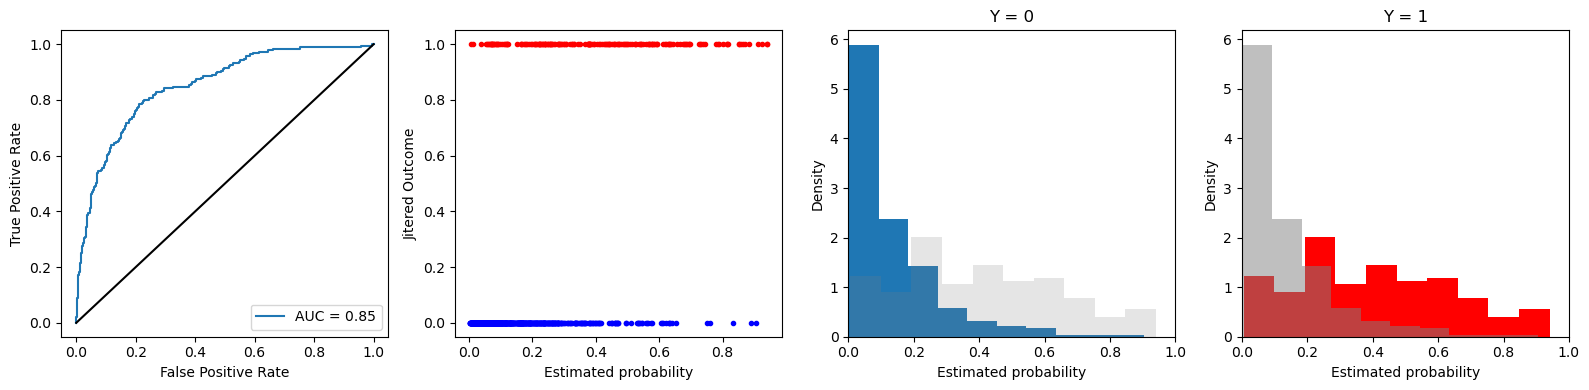

In [54]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,accuracy_score, confusion_matrix, auc

# Computing ROC curve
fpr, tpr, _ = roc_curve(df_res['y'], df_res['y_that']-min(df_res['y_that']))
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1,4, figsize = (16,4))

ax[0].plot(fpr, tpr, label=f'AUC = {str(round(roc_auc, 2))}')
ax[0].plot(np.linspace(0,1,10), np.linspace(0,1,10), color = 'black')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')

ax[1].plot(df_res.y_that[df_res.y == 0], df_res.y[df_res.y == 0],'.' ,color = 'blue')
ax[1].plot(df_res.y_that[df_res.y == 1], df_res.y[df_res.y == 1],'.',color = 'red')
ax[1].set_xlabel('Estimated probability')
ax[1].set_ylabel('Jitered Outcome')

ax[2].hist(df_res.y_that[df_res.y == 0], density = True)
ax[2].hist(df_res.y_that[df_res.y == 1], density = True, color = 'gray', alpha=0.2)
ax[2].set_xlabel('Estimated probability')
ax[2].set_ylabel('Density')
ax[2].set_title('Y = 0')
ax[2].set_xlim(0,1)

ax[3].hist(df_res.y_that[df_res.y == 1], density = True, color = 'red')
ax[3].hist(df_res.y_that[df_res.y == 0], density = True, color = 'gray', alpha=0.5)
ax[3].set_xlabel('Estimated probability')
ax[3].set_ylabel('Density')
ax[3].set_title('Y = 1')
ax[3].set_xlim(0,1)

plt.tight_layout()
plt.show()

* As we can see, the ROC curve presents a nice aspect and the metric, Area Under the Curve (AUC) presents a high value, that following [Hosmer and Lemeshow, 2013](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118548387), we can consider this model as a good discriminator.

* The density plots as for Y=0 well as for Y=1, show a reasonable separation in terms of occurrence of non excessive and excessive perception of sleepiness, where perception of non-excessive cases presents higher density bellow 0.3 and perception of excessive cases are well distributed along all the probability axis.

### 4.3.2. Confusion Matrix

In [70]:
df_res['y_that_bin'] = df_res['y_that'].apply(lambda x: 1 if x>= 0.30 else 0)
tn, fp, fn, tp = confusion_matrix(df_res['y'], df_res['y_that_bin']).ravel()
df_tmp = pd.DataFrame({'pred 1':[tp,fp], 'pred 0':[fn,tn], 'ind':['obs 1','obs 0']}).set_index('ind')
df_tmp.head()

,pred 1,pred 0
ind,,
obs 1,113,78
obs 0,86,737


### 4.2.3. Regression Coefficients Interpretation

In [5]:
df_coefs = model_LME2.coefs[['OR', 'OR_2.5_ci', 'OR_97.5_ci']].iloc[1:]
df_coefs.iloc[-2] = 1/df_coefs.iloc[-2]
df_coefs.iloc[-1] = 1/df_coefs.iloc[-1]
df_coefs.iloc[-4] = 1/df_coefs.iloc[-4]

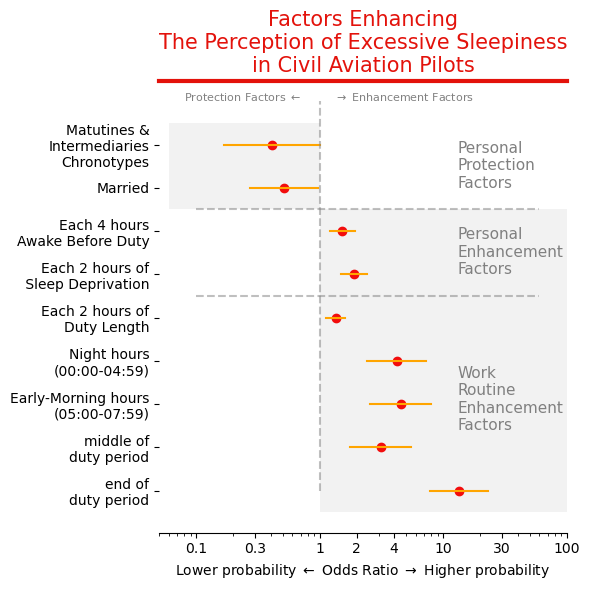

In [35]:
fig, ax = plt.subplots(1,1, figsize = (6,6))

for i in range(len(df_coefs)):
    ax.plot( [df_coefs['OR_2.5_ci'].iloc[i],df_coefs['OR_97.5_ci'].iloc[i]], [i,i], color = 'orange')

ax.scatter(df_coefs['OR'], list(range(len(df_coefs))), color = 'red')

ax.plot([1,1],[0,len(df_coefs)], '--', color = 'gray', alpha = 0.5)
ax.plot([0.1,60], [4.5, 4.5], '--', color = 'gray', alpha = 0.5)
ax.plot([0.1,60], [6.5, 6.5], '--', color = 'gray', alpha = 0.5)

ax.set_xscale('log')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('#E3120B')
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

labs = ['end of\nduty period','middle of\nduty period','Early-Morning hours\n(05:00-07:59)','Night hours\n(00:00-04:59)',
        'Each 2 hours of\nDuty Length', 'Each 2 hours of\n Sleep Deprivation',
        'Each 4 hours\nAwake Before Duty', 'Married', 'Matutines &\nIntermediaries\nChronotypes']
ax.set_yticks(list(range(len(df_coefs))), labels = labs)
ax.set_xticks([0.1, 0.3, 1, 2, 4, 10, 30, 100], labels = [0.1, 0.3, 1, 2, 4, 10, 30, 100])
ax.set_xlim([0.05, 100])

ax.set_xlabel(r"Lower probability $\leftarrow$ Odds Ratio $\rightarrow$ Higher probability")
ax.set_title('Factors Enhancing\nThe Perception of Excessive Sleepiness\nin Civil Aviation Pilots',
             color = '#E3120B', size = 15)

ax.text(0.08,9,r'Protection Factors $\leftarrow$',color = 'gray', size = 8 )
ax.text(1.3,9,   r'$\rightarrow$ Enhancement Factors',color = 'gray', size = 8 )
ax.text(13,1.4, 'Work\nRoutine\nEnhancement\nFactors', color = 'gray', size = 11)
ax.text(13,5, 'Personal\nEnhancement\nFactors', color = 'gray', size = 11)
ax.text(13,7, 'Personal\nProtection\nFactors', color = 'gray', size = 11)

ax.fill([1,100,100,1],[-0.5,-0.5,4.5,4.5], color = 'gray', alpha = 0.1, edgecolor = None)
ax.fill([1,100,100,1],[6.5,6.5,4.5,4.5], color = 'gray', alpha = 0.1, edgecolor = None)
ax.fill([1,0.06,0.06,1],[6.5,6.5,8.5,8.5], color = 'gray', alpha = 0.1 , edgecolor = None)
plt.tight_layout()
plt.show()
fig.savefig('figures/sleepiness_coeffs_odds.png')

In figure above the model's coefficients represented as odds ratio is shown. 

We can see that for all variables retained the 95% confidence bounds or error bars do not intercept the line 1, representing no significant odds ratio, confirming our previous analysis graphically. 

In [110]:
df_coefs.head(100)

,OR,OR_2.5_ci,OR_97.5_ci
duty_moment_2end,13.427765,7.789719,23.146518
duty_moment_2middle,3.107710,1.745873,5.531825
time_fill_kss_sps_2EM,4.512597,2.545574,7.999583
time_fill_kss_sps_2NI,4.212310,2.436683,7.281848
duty_length,1.344264,1.118802,1.615161
sleep_duration,1.908443,2.433933,1.496406
time_awake,1.528505,1.204229,1.940101
marital_statussingle,0.516176,0.972072,0.274092
Classification_2VES,0.407737,0.997700,0.166632


Table above shows the values of regression coefficients as odds ratio, so we can interpret it as:

* At the end of duty, the odds of perception of excessive sleepiness is 13.4($[7.8, 23.1]$) times that at the start of duty period, keeping all other covariates constant;

* At the middle of duty, the odds of perception of  excessive sleepiness is 3.1 ($[1.7, 5.5]$) times that at the start of duty period, keeping all other covariates constant.

* At the Early-Moring hours (05:00-07:59) the odds of perception of  excessive sleepiness is 4.5 ($[2.5, 7.9]$) times that at business hours (08:00 - 11:59), keeping all other covariates constant;

* At the Night hours (00:00-04:59) the odds of perception of excessive sleepiness is 4.2 ($[2.4, 7.3]$) times that at business hours (08:00 - 11:59), keeping all other covariates constant;

* For each 2 hours of duty length, the odds of perception of excessive sleepiness rises by 34% ($OR = 1.34 [1.12, 1.61]$) compared to any baseline, keeping all other covariates constant;

* For each 4 hours awake before the duty, the odds of perception of excessive sleepiness rises by 53% ($OR = 1.52 [1.20, 1.94]$) compared to any baseline, keeping all other covariates constant;

* For each 2 hours of sleep deprivation before the duty, the odds of perception of excessive sleepiness rises by 91% ($OR = 1.91 [1.50, 2.43]$) compared to any baseline, keeping all other covariates constant;

* Married and stable union participants have 49% ($OR = 0.51 [0.27, 0.97]$) less odds of perception of excessive sleepiness than bachelors participants.

* Matutines and Intermediaries chronotype participants have 51% ($OR = 0.49 [0.16, 0.99]$) less odds of perception of excessive sleepiness than Vespertines chronotypes.

### 4.3.4. Hosmer-Lemeshow test

Another test for goodness of fit is the Hosmer-Lemeshow statistics, that compares the deciles of the binary classification statistics, the Hosmer-Lemeshow statistics H is given by:

$$ H = \sum^{G}_{g = 1}\left(\frac{(O_{1g}-E_{1g})^2}{E_{1g}}+\frac{(O_{0g}-E_{0g})^2}{E_{0g}} \right) $$

where

$$ H \sim \chi^2_{G-2} $$

and G = 10, O represent the deciles of observations and E the deciles of model predictions. We will test the model under the null hypothesis that the observed and expected proportions are the same across all observations.

In [113]:
from scipy.stats import chi2

df_res['decile'] = pd.qcut(df_res['y_that'],10)

# Observed in all deciles
obsevents_1 = df_res['y'].groupby(df_res.decile, observed=True).sum()
obsevents_0 = df_res['y'].groupby(df_res.decile, observed=True).count() - obsevents_1

# Expected events
expevents_1 = (df_res['y_that']).groupby(df_res.decile, observed=True).sum()
expevents_0 = (df_res['y_that']).groupby(df_res.decile, observed=True).count() - expevents_1

# test statistics
H = (((obsevents_0 - expevents_0)**2)/(expevents_0)).sum() + (((obsevents_1 - expevents_1)**2)/(expevents_1)).sum()

# P-valor
pvalue = 1 - chi2.cdf(H , 10-2)

print('---------------------------------------')
print(f'H: {round(H,2)}; P-value: {round(pvalue,3)}')
print('---------------------------------------')

---------------------------------------
H: 12.64; P-value: 0.125
---------------------------------------


* The Hosmer and Lemeshow statistics presents a high p-values, indicating that we cannot reject the null hypothesis that the expected and observed proportions are the same across all deciles. So, we can conclude that the model is suitable to represent the data.

### 4.3.5. Variability among cluster or Due to Differences among Participants

The variability due to clusters or due to participants differences, can be assessed through the Median Odds Ratio (MOR). Following [Hosmer and Lemeshow, (2013)](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118548387) seminal book the MOR is given by:

$$\hat{MOR} = exp\left(z_{0.75}\sqrt[]{2 \hat{\sigma}^{2}}\right)$$

wherein $z_{0.75}$ is the upper quartile of the standardized normal distribution, and $\sigma^{2}$ is the intra-cluster variance. 

In [115]:
mor = np.exp(0.6745*np.sqrt(2*0.595))    # See model's output
print('------------------------------')
print(f'MOR: {mor}')
print('------------------------------')

------------------------------
MOR: 2.08713566783489
------------------------------


* For two randomly chosen individuals with the same values of covariates, the more prone individual have 109% (MOR = 2.09) more odds to perceive excessive sleepiness than the less prone individual in all such pairs.

---

## 5. Saving the Parsimonious model

In [118]:
from pymer4.io import save_model

file_path = "data/models/sleepiness_model.joblib"
save_model(model_LME2, file_path)

In [3]:
# from pymer4.io import load_model

# file_path = "data/models/sleepiness_model.joblib"
# model_LME2 = load_model(file_path)
#
# model_LME2

pymer4.models.Lmer(fitted = True, formula = kssd~duty_moment_2+time_fill_kss_sps_2+duty_length+sleep_duration+time_awake+marital_status+Classification_2+(1+1|Id), family = binomial)

---